In [23]:
import os
import pandas as pd
import requests
import json
import requests
import multiprocessing as mp
from random import randint
from time import sleep

import sys
sys.path.insert(0,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )
from rdkit import Chem


In [24]:
df = pd.read_pickle('/project/projectdirs/openmsi/projects/ben_run_pactolus/unique_compounds.pkl')
#df = pd.read_csv('/project/projectdirs/openmsi/projects/compound_data/jgi_molecules/new_jgi_compounds.csv')
# df.rename(columns = {'monoisotopoic_mw':'monoisotopic_mw'},inplace=True)
df = df.convert_objects(convert_numeric=True)
print df.keys()
df.sort_values('mono_isotopic_molecular_weight',inplace=True)


/global/common/edison/software/python/2.7-anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Index([u'chebi_id', u'chebi_url', u'description', u'formula', u'hmdb_id',
       u'hmdb_url', u'img_abc_id', u'inchi', u'inchi_key', u'iupac_name',
       u'kegg_id', u'kegg_url', u'lipidmaps_id', u'lipidmaps_url',
       u'metacyc_id', u'mono_isotopic_molecular_weight', u'name',
       u'neutralized_2d_inchi', u'neutralized_2d_inchi_key',
       u'neutralized_inchi', u'neutralized_inchi_key', u'num_free_radicals',
       u'number_components', u'permanent_charge', u'pubchem_compound_id',
       u'pubchem_url', u'source', u'synonyms', u'wikipedia_url'],
      dtype='object')


In [25]:
df.head(10)

,chebi_id,chebi_url,description,formula,hmdb_id,hmdb_url,img_abc_id,inchi,inchi_key,iupac_name,...,neutralized_inchi,neutralized_inchi_key,num_free_radicals,number_components,permanent_charge,pubchem_compound_id,pubchem_url,source,synonyms,wikipedia_url
151835,,,,H,,,NaN,InChI=1S/H,YZCKVEUIGOORGS-UHFFFAOYSA-N,,...,InChI=1S/H,YZCKVEUIGOORGS-UHFFFAOYSA-N,1,1,0,5362549.0,http://pubchem.ncbi.nlm.nih.gov/compound/5362549,wikidata,hydrogen(.)///Hydrogen atom///monohydrogen///H...,
62174,,,,H-,,,NaN,InChI=1S/H/q-1,KLGZELKXQMTEMM-UHFFFAOYSA-N,,...,InChI=1S/H/q-1,KLGZELKXQMTEMM-UHFFFAOYSA-N,0,1,-1,166653.0,http://pubchem.ncbi.nlm.nih.gov/compound/166653,wikidata,Hydride///hydrogen anion///AC1L4YHB///CHEBI:29...,
120579,CHEBI:18276,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,An elemental molecule consisting of two hydrog...,H2,HMDB01362,http://www.hmdb.ca/metabolites/HMDB01362,NaN,InChI=1S/H2/h1H,UFHFLCQGNIYNRP-UHFFFAOYSA-N,,...,InChI=1S/H2/h1H,UFHFLCQGNIYNRP-UHFFFAOYSA-N,0,1,0,783.0,http://pubchem.ncbi.nlm.nih.gov/compound/783,chebi///hmdb,Hydrogen///Dihydrogen///Molecular hydrogen///1...,
120563,CHEBI:29299,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,,H2,,,NaN,InChI=1S/H2/h1H/i1+0H,UFHFLCQGNIYNRP-HXFQMGJMSA-N,,...,InChI=1S/H2/h1H/i1+0H,UFHFLCQGNIYNRP-HXFQMGJMSA-N,0,1,0,6914304.0,http://pubchem.ncbi.nlm.nih.gov/compound/6914304,chebi,diprotium///CHEBI:29299///(1)H2,
120572,CHEBI:29294,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,,H2,,,NaN,InChI=1S/H2/h1H/i1+1D,UFHFLCQGNIYNRP-VVKOMZTBSA-N,,...,InChI=1S/H2/h1H/i1+1D,UFHFLCQGNIYNRP-VVKOMZTBSA-N,0,1,0,24523.0,http://pubchem.ncbi.nlm.nih.gov/compound/24523,chebi///wikidata,DEUTERIUM///Dideuterium///7782-39-0///Heavy hy...,
120557,CHEBI:29298,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,,H2,,,NaN,InChI=1S/H2/h1H/i1+2T,UFHFLCQGNIYNRP-JMRXTUGHSA-N,,...,InChI=1S/H2/h1H/i1+2T,UFHFLCQGNIYNRP-JMRXTUGHSA-N,0,1,0,24824.0,http://pubchem.ncbi.nlm.nih.gov/compound/24824,chebi,TRITIUM///Hydrogen-3///10028-17-8///ditritium/...,
39732,CHEBI:33979,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,,Li+,,,NaN,InChI=1S/Li/q+1,HBBGRARXTFLTSG-UHFFFAOYSA-N,,...,InChI=1S/Li/q+1,HBBGRARXTFLTSG-UHFFFAOYSA-N,0,1,1,28486.0,http://pubchem.ncbi.nlm.nih.gov/compound/28486,chebi///wikidata,lithium ion///Lithium(1+)///Lithium element///...,
134108,,,,Li,,,NaN,InChI=1S/Li,WHXSMMKQMYFTQS-UHFFFAOYSA-N,,...,InChI=1S/Li,WHXSMMKQMYFTQS-UHFFFAOYSA-N,1,1,0,3028194.0,http://pubchem.ncbi.nlm.nih.gov/compound/3028194,wikidata,"LITHIUM///7439-93-2///litio///Lithium, metalli...",
113354,CHEBI:125696,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,,HLi,,,NaN,InChI=1S/Li.H,SIAPCJWMELPYOE-UHFFFAOYSA-N,,...,InChI=1S/Li.H,SIAPCJWMELPYOE-UHFFFAOYSA-N,2,1,0,NaN,,chebi,,
97433,CHEBI:35102,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,,Be+2,,,NaN,InChI=1S/Be/q+2,PWOSZCQLSAMRQW-UHFFFAOYSA-N,,...,InChI=1S/Be/q+2,PWOSZCQLSAMRQW-UHFFFAOYSA-N,0,1,2,107649.0,http://pubchem.ncbi.nlm.nih.gov/compound/107649,chebi///wikidata,beryllium(2+)///Beryllium atom///Beryllium ele...,


In [47]:
inchis = df[(~ df.inchi.str.contains('\.')) & (df.formula.str.contains('C'))  & (df.mono_isotopic_molecular_weight < 1200) & (~ pd.isnull(df.inchi))].inchi
inchis = inchis[140000:]
len(inchis)

37573

In [43]:
N = 400
chunks = [inchis[x:x+N] for x in xrange(0, len(inchis), N)]
len(chunks)

94

(192038, 29) 37573


<IPython.core.display.Javascript object>


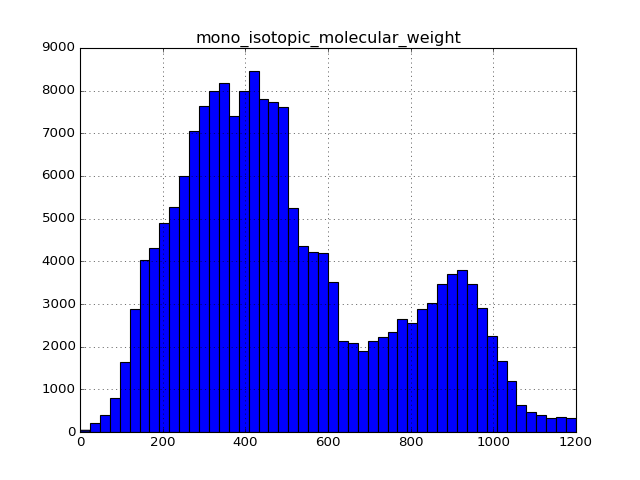

In [49]:
print df.shape, len(inchis)
%matplotlib notebook
from matplotlib import pyplot as plt
a = df.hist(column=u'mono_isotopic_molecular_weight',bins=50,range=(0,1200))
# plt.xlim(0,1200)

In [ ]:
import glob as glob
out_files = glob.glob('/scratch2/scratchdirs/bpb/logs/*_out.txt')
len(out_files)
incomplete_files = []
for i,f in enumerate(out_files):
    with open(f,'r') as fid:
        if len(fid.readlines()) < 3000:
            incomplete_files.append(f)
# sorted(incomplete_files)

In [46]:
import glob as glob
files = sorted(glob.glob('/global/homes/b/bpb/inchi_metatlas/*.txt'))
# print len(files),files
script_names = []
for f in files:
    with open('make_pactolus_trees_script.sh','r') as fid:
        a_new_line = fid.read().replace('/scratch2/scratchdirs/bpb/inchi/inchis_3.txt',f).replace('job_pactolus_realtime1',os.path.basename(f).split('.')[0]).replace('time=','time=3').replace('realtime','regular')
    out_file = os.path.join('/global/homes/b/bpb/pactolus_scripts/',os.path.basename(f).split('.')[0] + '.sbatch')
    script_names.append(out_file)
    with open(out_file,'w') as out_fid:
        out_fid.write(a_new_line)
with open('/global/homes/b/bpb/pactolus_scripts/level_3_run_all_scripts.sh','w') as fid:
    for i,s in enumerate(script_names):
#         if (i > 149):# & (i < 150):
        fid.write('sbatch %s\n'%s)

In [ ]:
# import glob as glob
# files = sorted(glob.glob('/global/homes/b/bpb/inchi_metatlas/*.txt'))
# # print len(files),files
# script_names = []
# for f in files:
#     with open('make_pactolus_trees_script.sh','r') as fid:
#         a_new_line = fid.read().replace('/scratch2/scratchdirs/bpb/inchi/inchis_3.txt',f).replace('job_pactolus_realtime1',os.path.basename(f).split('.')[0]).replace('realtime','shared').replace('--time=4','--time=36')
#     out_file = os.path.join('/global/homes/b/bpb/pactolus_scripts/',os.path.basename(f).split('.')[0] + '_shared_queue.sbatch')
#     script_names.append(out_file)
#     with open(out_file,'w') as out_fid:
#         out_fid.write(a_new_line)
# with open('/global/homes/b/bpb/pactolus_scripts/run_all_scripts_shared_queue.sh','w') as fid:
#     for s in script_names[650:]:
#         fid.write('sbatch %s\n'%s)

In [41]:
%system cat /global/homes/b/bpb/pactolus_scripts/inchis_000.sbatch

['#!/bin/bash -l',
 '#SBATCH --account=m1541',
 '#SBATCH --job-name=inchis_000',
 '#SBATCH --time=4:00:00',
 '#SBATCH --output=/scratch2/scratchdirs/bpb/logs/inchis_000_out.txt',
 '#SBATCH --error=/scratch2/scratchdirs/bpb/logs/inchis_000_err.txt',
 '#SBATCH --partition=realtime',
 '',
 'module load python/2.7-anaconda',
 '',
 'export PYTHONPATH=/scratch2/scratchdirs/bpb/repos/metaiq:$PYTHONPATH',
 'export PYTHONPATH=/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages:$PYTHONPATH',
 '',
 '',
 'srun -N 1 python /scratch2/scratchdirs/bpb/repos/metaiq/pactolus/mp_generate_frag_dag.py --inchi_file /global/homes/b/bpb/inchi_metatlas/inchis_000.txt --isotope_file /scratch2/scratchdirs/bpb/repos/metaiq/pactolus/max_abundance_isotopes.csv --output_dir /scratch2/scratchdirs/bpb/level_3_trees --error_log /scratch2/scratchdirs/bpb/logs/gen_tree_log.txt --max_depth 3',
 '']

In [ ]:

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
mols = [Chem.MolFromInchi(m) for m in inchis[-9:]]


In [ ]:
images = Draw.MolsToGridImage(mols,molsPerRow=3, useSVG=True)
# Draw.MolsToGridImage([f['frag_mol_h'] for f in f_tree_2.fragment_list],molsPerRow=7,useSVG=True)


In [ ]:
baumin_inchi = df[(df.metatlas_inchi_key.str.contains('JZRMMLYGOBWIGY')) & (~ pd.isnull(df.metatlas_inchi))].metatlas_inchi
with open('/global/homes/b/bpb/inchi/baumin_inchi.txt','w') as fid:
    for my_inchi in baumin_inchi:
        m = Chem.MolFromInchi(my_inchi)
        if m:
            fid.write('%s\n'%my_inchi)
baumin_inchi

In [ ]:
images.data

In [ ]:
# cell_out = _97
with open('9 molecules.svg','w') as fid:
    fid.write(str(images.data.replace('font-family:sans-serif;','')))

In [ ]:
from IPython.display import SVG, display
SVG(data=_97)

In [ ]:
images.save('9 big molecules.png')

In [ ]:
%system mkdir ~/inchi_metatlas

In [ ]:
# with open('/global/homes/b/bpb/inchi/inchis_all.txt','w') as fid:
#     for my_inchi in inchis:
#         m = Chem.MolFromInchi(my_inchi)
#         if m:
#             fid.write('%s\n'%my_inchi)

In [44]:
%system rm /global/homes/b/bpb/inchi_metatlas/*.txt
for i,inchi_list in enumerate(chunks):
    with open('/global/homes/b/bpb/inchi_metatlas/inchis_%03d.txt'%i,'w') as fid:
        for my_inchi in inchi_list:
            fid.write('%s\n'%my_inchi)

# remove those that have already been done

In [ ]:
import glob
files = glob.glob(os.path.join(out_dir,'*.json'))
done_inchi_key = []
for f in files:
    done_inchi_key.append(os.path.basename(f).split('.')[0])
inchi_keys = list(set(inchi_keys) - set(done_inchi_key))

In [ ]:
len(inchi_keys)

In [ ]:
def write_pubchem_info_to_file(inchi_key):
    suffix = '.json'
    fname = os.path.join(out_dir, inchi_key + suffix)
    if not os.path.isfile(fname):
        url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/%s/synonyms/json'%inchi_key
        response = requests.get(url)
        try: 
            with open(fname, 'w') as fid:
                json.dump(response.json(), fid)
        except:
            print "could not query", inchi_key

In [ ]:
for ik in inchi_keys[1:]:
    print ik
    write_pubchem_info_to_file(ik)

In [ ]:
# pool = mp.Pool(processes=20)
# pool.map(write_pubchem_info_to_file, inchi_keys[1:100])

In [ ]:
url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/%s/synonyms/json'%'CKLJMWTZIZZHCS-REOHCLBHSA-N'
response = requests.get(url)
response.json()

In [ ]:
response.json()

In [ ]:
url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/%s/json'%'Baumin'
response = requests.get(url)
response.json()